# Convolutional Neural Networks

In [1]:
#Imports
import numpy as np
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [2]:
#Preferences
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

### Data Preparation

Images from Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats

In [3]:
# Organize data into train, valid, test dirs
os.chdir("data/dogs-vs-cats")

In [4]:
if os.path.isdir("train/dog") is False:
    os.makedirs("train/dog")
    os.makedirs("train/cat")
    os.makedirs("val/dog")
    os.makedirs("val/cat")
    os.makedirs("test/dog")
    os.makedirs("test/cat")
    
    for c in random.sample(glob.glob("train1/cat*"), 1000):
        shutil.move(c, "train/cat" )
    for c in random.sample(glob.glob("train1/dog*"), 1000):
        shutil.move(c, "train/dog" )
    
    for c in random.sample(glob.glob("train1/cat*"), 500):
        shutil.move(c, "val/cat" )
    for c in random.sample(glob.glob("train1/dog*"), 500):
        shutil.move(c, "val/dog" )
    
    for c in random.sample(glob.glob("train1/cat*"), 100):
        shutil.move(c, "test/cat" )
    for c in random.sample(glob.glob("train1/dog*"), 100):
        shutil.move(c, "test/dog" )

os.chdir("../../")

In [5]:
#path variables
train_path = "data/dogs-vs-cats/train"
val_path = "data/dogs-vs-cats/val"
test_path = "data/dogs-vs-cats/test"

In [6]:
#Creates keras image generator. Applies vgg16 preprocessing to images first.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10)

Found 2000 images belonging to 2 classes.


In [7]:
#Creates keras image generator. Applies vgg16 preprocessing to images first.
val_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=val_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10)

Found 1000 images belonging to 2 classes.


In [8]:
#Creates keras image generator. Applies vgg16 preprocessing to images first.
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10, shuffle=False)

Found 200 images belonging to 2 classes.


In [9]:
#Verifying the correct number of images
assert train_batches.n == 2000
assert val_batches.n == 1000
assert test_batches.n == 200

In [10]:
#Verifying the correct number of classes
assert train_batches.num_classes == val_batches.num_classes == test_batches.num_classes == 2

In [11]:
imgs, labels = next(train_batches)

In [12]:
#Plots images in a grid
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

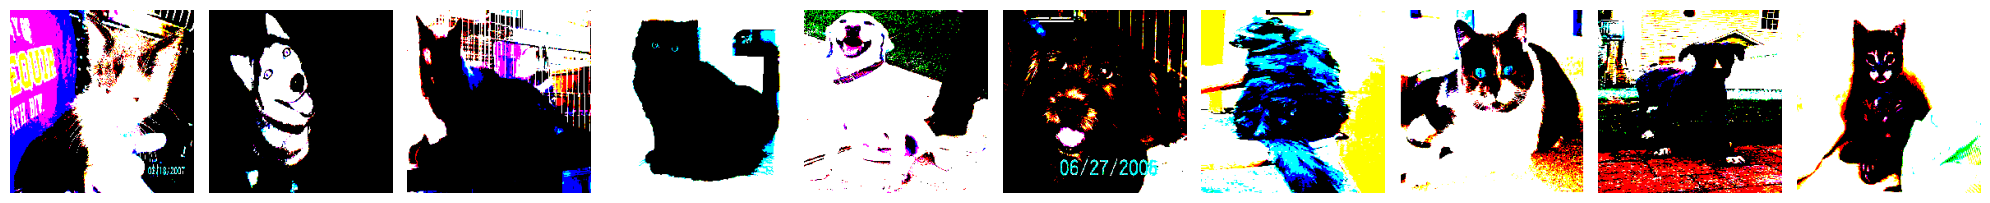

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [13]:
#Color looks distorted because of preprocessing
plotImages(imgs)
print(labels)

### Build and Train a CNN

In [14]:
#Remember target_size is the same as input_shape
#Input shape is height, width and colors
#General practise to increase "filters" with each layer.
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding = "same", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same"),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation="softmax"),
])

2023-07-23 18:35:02.357303: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [16]:
# Due to having two outputs, could use binary_categorical_crossentropy loss function but would require. 
# Last/Output layer would need one node and Signoid activation fuction. 
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# Note: x is specified but y is not because the generator contains the labels.
model.fit(x=train_batches, validation_data=val_batches, epochs=10, verbose=2)

Epoch 1/10
200/200 - 78s - loss: 9.2223 - accuracy: 0.5940 - val_loss: 2.5691 - val_accuracy: 0.6150 - 78s/epoch - 390ms/step
Epoch 2/10
200/200 - 128s - loss: 0.7228 - accuracy: 0.8355 - val_loss: 1.6693 - val_accuracy: 0.6640 - 128s/epoch - 638ms/step
Epoch 3/10
200/200 - 137s - loss: 0.1336 - accuracy: 0.9540 - val_loss: 1.6783 - val_accuracy: 0.6610 - 137s/epoch - 687ms/step
Epoch 4/10
200/200 - 98s - loss: 0.0342 - accuracy: 0.9885 - val_loss: 1.8945 - val_accuracy: 0.6510 - 98s/epoch - 491ms/step
Epoch 5/10
200/200 - 74s - loss: 0.0087 - accuracy: 0.9985 - val_loss: 1.7877 - val_accuracy: 0.6390 - 74s/epoch - 371ms/step
Epoch 6/10
200/200 - 77s - loss: 0.0038 - accuracy: 0.9995 - val_loss: 1.7515 - val_accuracy: 0.6710 - 77s/epoch - 383ms/step
Epoch 7/10
200/200 - 78s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 1.7637 - val_accuracy: 0.6740 - 78s/epoch - 389ms/step
Epoch 8/10
200/200 - 112s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.7874 - val_accuracy: 0.6700 - 112s/epoch

### Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

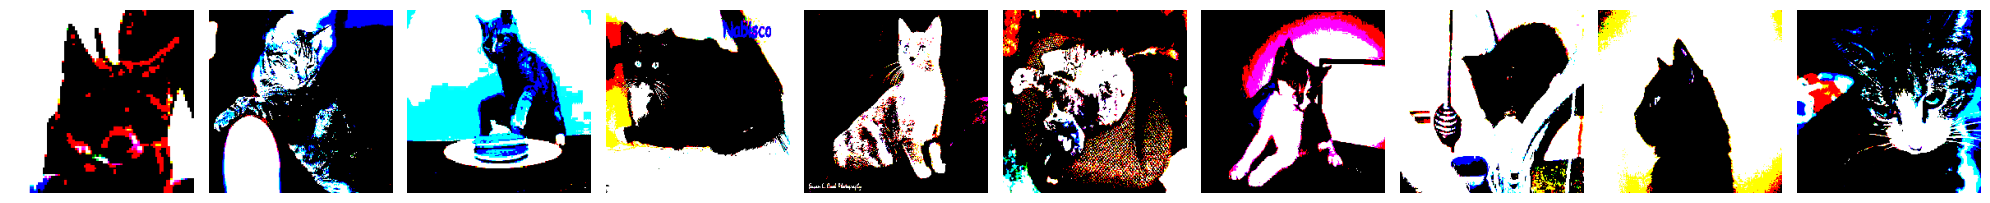

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [18]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [19]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [20]:
predictions = model.predict(x=test_batches, verbose=0)

In [21]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [22]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    """

    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [24]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[68 32]
 [38 62]]


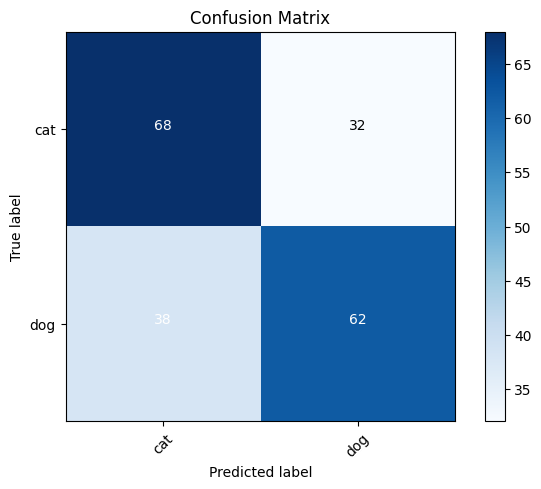

In [25]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title = "Confusion Matrix")

### Build Fine-tuned VGG16 model

In [26]:
#Download model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [27]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {"non_trainable_params": non_trainable_params, "trainable_params": trainable_params}

In [29]:
params = count_params(vgg16_model)
assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 138357544

In [30]:
type(vgg16_model)

keras.engine.functional.Functional

In [31]:
#Change the VGG16 model into a Sequential model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [33]:
params = count_params(model)
assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 134260544

In [34]:
for layer in model.layers:
    layer.trainable = False

In [35]:
#Add in our own output layer
model.add(Dense(units=2, activation="softmax"))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [37]:
params = count_params(model)
assert params["non_trainable_params"] == 134260544
assert params["trainable_params"] == 8194

### Train the fine-tuned VGG16 Model